<a href="https://colab.research.google.com/github/lutilipe/sistema-controle-de-fadiga/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install numpy scikit-fuzzy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=ec753885351b2dacdfd509c52a7418cdb6e79a5bfb7ac459886ce003deb20712
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


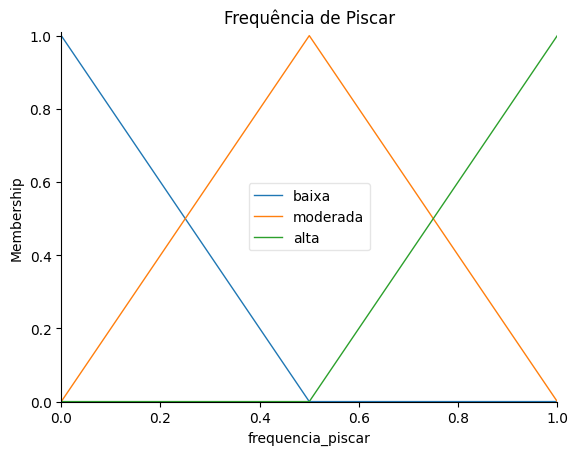

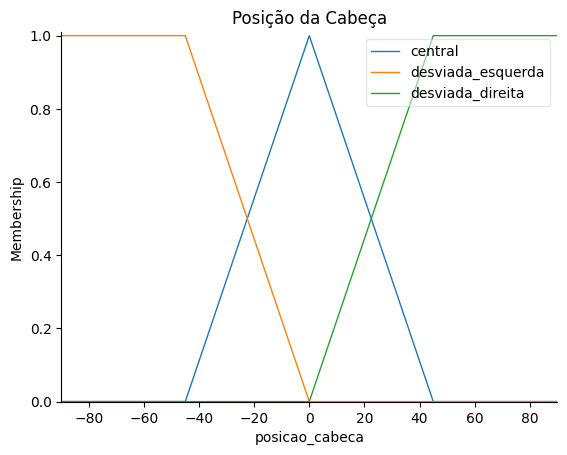

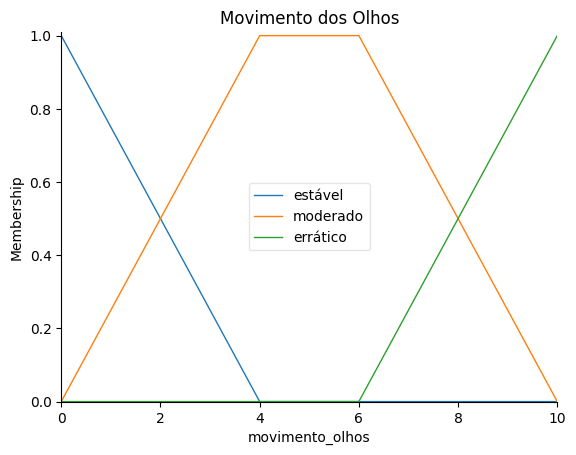

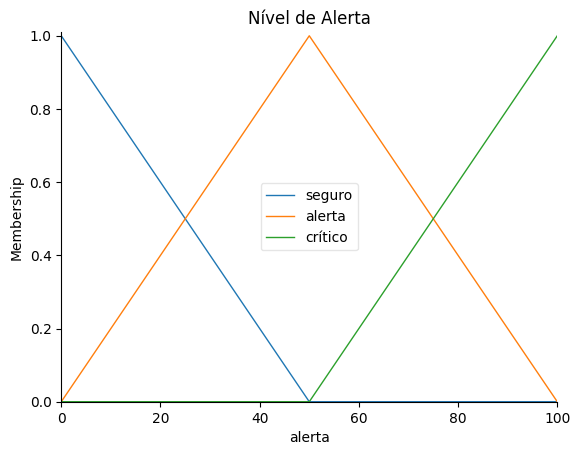

17.499999999999996


In [3]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# Variáveis de Entrada e Saída
frequencia_piscar = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'frequencia_piscar')
posicao_cabeca = ctrl.Antecedent(np.arange(-90, 91, 1), 'posicao_cabeca')
movimento_olhos = ctrl.Antecedent(np.arange(0, 11, 1), 'movimento_olhos')
alerta = ctrl.Consequent(np.arange(0, 101, 1), 'alerta')

# Configuração das Funções de Pertinência
frequencia_piscar.automf(names=['baixa', 'moderada', 'alta'])

posicao_cabeca['central'] = fuzz.trimf(posicao_cabeca.universe, [-45, 0, 45])
posicao_cabeca['desviada_esquerda'] = fuzz.trapmf(posicao_cabeca.universe, [-90, -90, -45, 0])
posicao_cabeca['desviada_direita'] = fuzz.trapmf(posicao_cabeca.universe, [0, 45, 90, 90])

movimento_olhos['estável'] = fuzz.trimf(movimento_olhos.universe, [0, 0, 4])
movimento_olhos['moderado'] = fuzz.trapmf(movimento_olhos.universe, [0, 4, 6, 10])
movimento_olhos['errático'] = fuzz.trimf(movimento_olhos.universe, [6, 10, 10])

alerta.automf(names=['seguro', 'alerta', 'crítico'])

# Sistema Fuzzy
rules = [
    ctrl.Rule(frequencia_piscar['alta'] & posicao_cabeca['central'] & movimento_olhos['errático'], alerta['crítico']),
    ctrl.Rule(frequencia_piscar['alta'] & posicao_cabeca['central'] & (movimento_olhos['estável']), alerta['alerta']),
    ctrl.Rule(frequencia_piscar['alta'] & posicao_cabeca['central'] & (movimento_olhos['moderado']), alerta['alerta']),
    ctrl.Rule(frequencia_piscar['moderada'] & posicao_cabeca['central'] & (movimento_olhos['errático']), alerta['alerta']),
    ctrl.Rule(frequencia_piscar['moderada'] & posicao_cabeca['central'] & (movimento_olhos['moderado']), alerta['alerta']),
    ctrl.Rule(frequencia_piscar['moderada'] & posicao_cabeca['central'] & movimento_olhos['estável'], alerta['seguro']),
    ctrl.Rule(frequencia_piscar['baixa'] & posicao_cabeca['central'] & movimento_olhos['errático'], alerta['alerta']),
    ctrl.Rule(frequencia_piscar['baixa'] & posicao_cabeca['central'] & (movimento_olhos['moderado']), alerta['seguro']),
    ctrl.Rule(frequencia_piscar['baixa'] & posicao_cabeca['central'] & (movimento_olhos['estável']), alerta['seguro']),

    ctrl.Rule(frequencia_piscar['alta'] & (posicao_cabeca['desviada_esquerda'] | posicao_cabeca['desviada_direita']) & (movimento_olhos['moderado']), alerta['crítico']),
    ctrl.Rule(frequencia_piscar['alta'] & (posicao_cabeca['desviada_esquerda'] | posicao_cabeca['desviada_direita']) & (movimento_olhos['errático']), alerta['crítico']),
    ctrl.Rule(frequencia_piscar['alta'] & (posicao_cabeca['desviada_esquerda'] | posicao_cabeca['desviada_direita']) & movimento_olhos['estável'], alerta['alerta']),
    ctrl.Rule(frequencia_piscar['moderada'] & (posicao_cabeca['desviada_esquerda'] | posicao_cabeca['desviada_direita']) & movimento_olhos['errático'], alerta['crítico']),
    ctrl.Rule(frequencia_piscar['moderada'] & (posicao_cabeca['desviada_esquerda'] | posicao_cabeca['desviada_direita']) & (movimento_olhos['moderado']), alerta['alerta']),
    ctrl.Rule(frequencia_piscar['moderada'] & (posicao_cabeca['desviada_esquerda'] | posicao_cabeca['desviada_direita']) & (movimento_olhos['estável']), alerta['seguro']),
    ctrl.Rule(frequencia_piscar['baixa'] & (posicao_cabeca['desviada_esquerda'] | posicao_cabeca['desviada_direita']) & movimento_olhos['errático'], alerta['alerta']),
    ctrl.Rule(frequencia_piscar['baixa'] & (posicao_cabeca['desviada_esquerda'] | posicao_cabeca['desviada_direita']) & movimento_olhos['moderado'], alerta['seguro']),
    ctrl.Rule(frequencia_piscar['baixa'] & (posicao_cabeca['desviada_esquerda'] | posicao_cabeca['desviada_direita']) & movimento_olhos['estável'], alerta['seguro']),
]
vigilance_system = ctrl.ControlSystem(rules)
vigilance_sim = ctrl.ControlSystemSimulation(vigilance_system)


# Plots das Funções de Pertinência
frequencia_piscar.view()
plt.title('Frequência de Piscar')
plt.show()

posicao_cabeca.view()
plt.title('Posição da Cabeça')
plt.show()

movimento_olhos.view()
plt.title('Movimento dos Olhos')
plt.show()

alerta.view()
plt.title('Nível de Alerta')
plt.show()

# Teste
vigilance_sim.input['frequencia_piscar'] = 0
vigilance_sim.input['posicao_cabeca'] = 0
vigilance_sim.input['movimento_olhos'] = 3
vigilance_sim.compute()
print(vigilance_sim.output['alerta'])

In [4]:
import plotly.graph_objects as go
from sklearn.cluster import KMeans
import skfuzzy.cluster as fcluster
import numpy as np
from sklearn.preprocessing import MinMaxScaler

data_size = 5000

# Gerando valores aleatorios para inputs
first_column = np.linspace(0, 1, data_size)
second_column = np.random.randint(-90, 91, size=data_size)
third_column = np.random.uniform(0, 10, size=data_size)

# Matriz de entrada
data = np.column_stack((first_column, second_column, third_column))
z = []

for i in range(0,data_size):
  vigilance_sim.input['frequencia_piscar'] = data[i][0]
  vigilance_sim.input['posicao_cabeca'] = data[i][1]
  vigilance_sim.input['movimento_olhos'] = data[i][2]
  vigilance_sim.compute()
  z.append(vigilance_sim.output['alerta'])

# Plotando inputs em um grafico 3D e colorindo de acordo com saida do sistema fuzzy
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=data[:, 0], y=data[:, 1], z=data[:, 2],
    mode='markers',
    marker=dict(size=4, color=z,
        colorscale='Inferno',
        opacity=0.8,
        colorbar=dict(title='Nível de alerta'),cmin=0,cmax=100),
))
fig.update_layout(
    scene=dict(
        xaxis_title='Frequência de Piscar',
        yaxis_title='Posição da Cabeça',
        zaxis_title='Movimento dos Olhos'
    ),
    width=1000, height=750,
    margin=dict(l=65, r=50, b=65, t=90)
)
fig.show()


In [5]:
# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Diretórios do dataset no Google Drive
train_dir = '/content/drive/MyDrive/UFMG/dataset_new/train'
test_dir = '/content/drive/MyDrive/UFMG/dataset_new/test'

import numpy as np
import cv2
import os
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Função para carregar imagens de um diretório
def load_images_from_directory(directory, class_map):
    image_paths = []
    labels = []
    for class_label in os.listdir(directory):
        class_dir = os.path.join(directory, class_label)
        if os.path.isdir(class_dir):
            for image_file in os.listdir(class_dir):
                image_paths.append(os.path.join(class_dir, image_file))
                labels.append(class_map[class_label])
    return image_paths, labels

# Mapeando as classes
class_map = {'Open': 0, 'Closed': 1, 'no_yawn': 2, 'yawn': 3}

# Carregar imagens de treino
train_image_paths, train_labels = load_images_from_directory(train_dir, class_map)

# Função para carregar e processar uma imagem
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (64, 64))
    image = image / 255.0  # Normalizar a imagem
    return image

# Pré-processar os dados
def preprocess_data(image_paths, labels):
    images = []
    for image_path in image_paths:
        images.append(load_image(image_path))
    return np.array(images), np.array(labels)

# Pré-processar os dados de treino
X_train, y_train = preprocess_data(train_image_paths, train_labels)

# Converter as imagens para características simplificadas (por exemplo, média dos valores de pixel)
blink_frequency = np.mean(X_train, axis=(1, 2, 3))

# Gerar outros dados simulados para complementar
# Aqui você pode usar outras características das imagens ou dados adicionais
head_position = np.random.randint(-90, 91, size=len(blink_frequency))
eye_movement = np.random.uniform(0, 10, size=len(blink_frequency))

# Combinar todas as características em uma matriz de dados
data = np.column_stack((blink_frequency, head_position, eye_movement))

print(data)

Mounted at /content/drive
[[  0.52390504  40.           9.5999826 ]
 [  0.40217014 -33.           0.68771264]
 [  0.35614596  62.           2.94483478]
 ...
 [  0.40069189 -87.           4.14741288]
 [  0.40552588 -76.           2.74802102]
 [  0.41005955 -35.           1.77904292]]


In [6]:
z = []

print(len(blink_frequency))

for i in range(0,len(blink_frequency)):
  vigilance_sim.input['frequencia_piscar'] = data[i][0]
  vigilance_sim.input['posicao_cabeca'] = data[i][1]
  vigilance_sim.input['movimento_olhos'] = data[i][2]
  vigilance_sim.compute()
  z.append(vigilance_sim.output['alerta'])

# Plotando inputs em um grafico 3D e colorindo de acordo com saida do sistema fuzzy
fig_system = go.Figure()
fig_system.add_trace(go.Scatter3d(
    x=data[:, 0], y=data[:, 1], z=data[:, 2],
    mode='markers',
    marker=dict(size=4, color=z,
        colorscale='Inferno',
        opacity=0.8,
        colorbar=dict(title='Nível de alerta'),cmin=0,cmax=100),
))
fig_system.update_layout(
    scene=dict(
        xaxis_title='Frequência de Piscar',
        yaxis_title='Posição da Cabeça',
        zaxis_title='Movimento dos Olhos'
    ),
    width=1000, height=750,
    margin=dict(l=65, r=50, b=65, t=90)
)
fig_system.show()

2467
